<a href="https://colab.research.google.com/github/tk1cntt/catboost-samples/blob/ea/catboost_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-cp36-none-any.whl size=28718 sha256=73f72b736c93ad1f80c1387c00f5902cec88aac71eb55d111dae64fbd8651362
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [ ]:
#import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime
import random
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#mt5.initialize()

LOOK_BACK = 5
MA_PERIODS = [13, 21, 55, 89, 200]

SYMBOL = 'EURUSD'
SPREAD = 0.00020
STOPLOSS = 0.00100
TAKEPROFIT = 0.00200

#TIMEFRAME = mt5.TIMEFRAME_H1
START_DATE = datetime(2020, 1, 1)
TSTART_DATE = datetime(2015, 1, 1)
STOP_DATE = datetime(2021, 1, 1)

#prices = pd.read_csv("EURUSD_mt5_bars_h1.csv")[['date', 'time', 'close']]
#prices

from ta import add_all_ta_features
from ta.utils import dropna

import warnings
warnings.filterwarnings('ignore')

def pca_plot(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components = 5)
    components = pd.DataFrame(pca.fit_transform(data[data.columns[1:-1]]))
    components['labels'] = data['labels'].reset_index(drop = True)
    import seaborn as sns
    g = sns.PairGrid(components, hue="labels", height=1.2)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    plt.show()
    
def export_model_to_MQL_code(model):
    model.save_model('catmodel.h',
           format="cpp",
           export_parameters=None,
           pool=None)

    # add variables
    code = 'int ' + 'loock_back = ' + str(LOOK_BACK) + ';\n'
    code += 'int hnd[];\n'
    code += 'int OnInit() {\n'
    code +=     'ArrayResize(hnd,' + str(len(MA_PERIODS)) + ');\n'

    count = len(MA_PERIODS) - 1
    for i in MA_PERIODS:
        code +=     'hnd[' + str(count) + ']' + ' =' + ' iMA(NULL,PERIOD_CURRENT,' + str(i) + ',0,MODE_SMA,PRICE_CLOSE);\n'
        count -= 1

    code += 'return(INIT_SUCCEEDED);\n'
    code += '}\n\n'

    # get features
    code += 'void fill_arays(int look_back, double &features[]) {\n'
    code += '   double ma[], pr[], ret[];\n'
    code += '   ArrayResize(ret,' + str(LOOK_BACK) +');\n'
    code += '   CopyClose(NULL,PERIOD_CURRENT,1,look_back,pr);\n'
    code += '   for(int i=0;i<' + str(len(MA_PERIODS)) +';i++) {\n'
    code += '       CopyBuffer(hnd[' + 'i' + '], 0, 1, look_back, ma);\n'
    code += '       for(int f=0;f<' + str(LOOK_BACK) +';f++)\n'
    code += '           ret[f] = pr[f] - ma[f];\n'
    code += '       ArrayInsert(features, ret, ArraySize(features), 0, WHOLE_ARRAY); }\n'
    code += '   ArraySetAsSeries(features, true);\n'
    code += '}\n\n'

    # add CatBosst
    code += 'double catboost_model' + '(const double &features[]) { \n'
    code += '    '
    with open('catmodel.h', 'r') as file:
        data = file.read()
        code += data[data.find("unsigned int TreeDepth"):data.find("double Scale = 1;")]
    code +='\n\n'
    code+= 'return ' + 'ApplyCatboostModel(features, TreeDepth, TreeSplits , BorderCounts, Borders, LeafValues); } \n\n'

    code += 'double ApplyCatboostModel(const double &features[],uint &TreeDepth_[],uint &TreeSplits_[],uint &BorderCounts_[],float &Borders_[],double &LeafValues_[]) {\n\
    uint FloatFeatureCount=ArrayRange(BorderCounts_,0);\n\
    uint BinaryFeatureCount=ArrayRange(Borders_,0);\n\
    uint TreeCount=ArrayRange(TreeDepth_,0);\n\
    bool     binaryFeatures[];\n\
    ArrayResize(binaryFeatures,BinaryFeatureCount);\n\
    uint binFeatureIndex=0;\n\
    for(uint i=0; i<FloatFeatureCount; i++) {\n\
       for(uint j=0; j<BorderCounts_[i]; j++) {\n\
          binaryFeatures[binFeatureIndex]=features[i]>Borders_[binFeatureIndex];\n\
          binFeatureIndex++;\n\
       }\n\
    }\n\
    double result=0.0;\n\
    uint treeSplitsPtr=0;\n\
    uint leafValuesForCurrentTreePtr=0;\n\
    for(uint treeId=0; treeId<TreeCount; treeId++) {\n\
       uint currentTreeDepth=TreeDepth_[treeId];\n\
       uint index=0;\n\
       for(uint depth=0; depth<currentTreeDepth; depth++) {\n\
          index|=(binaryFeatures[TreeSplits_[treeSplitsPtr+depth]]<<depth);\n\
       }\n\
       result+=LeafValues_[leafValuesForCurrentTreePtr+index];\n\
       treeSplitsPtr+=currentTreeDepth;\n\
       leafValuesForCurrentTreePtr+=(1<<currentTreeDepth);\n\
    }\n\
    return 1.0/(1.0+MathPow(M_E,-result));\n\
    }'

    file = open('./' + 'cat_model_clustering' + '.mqh', "w")
    file.write(code)
    file.close()
    print('The file ' + 'cat_model' + '.mqh ' + 'has been written to disc')

In [ ]:

def v2get_prices(START, STOP):
  #df_prices = pd.read_csv("./sample_data/EURUSD_mt5_bars_h1.csv")[['date', 'time', 'open', 'close', 'high', 'low', 'vol']]
  df_prices = pd.read_csv("./sample_data/EURUSD_mt5_bars_h1_2019_2020.csv")[['date', 'time', 'open', 'close', 'high', 'low', 'vol']]
  return v2_get_prices(df_prices)

def v2get_prices_test(START, STOP):
  #df_prices = pd.read_csv("./sample_data/EURUSD_mt5_bars_h1_test.csv")[['date', 'time', 'open', 'close', 'high', 'low', 'vol']]
  df_prices = pd.read_csv("./sample_data/EURUSD_mt5_bars_h1_2016_2020.csv")[['date', 'time', 'open', 'close', 'high', 'low', 'vol']]
  return v2_get_prices(df_prices)

def v2_get_prices(df_prices):
  cb_prices = pd.DataFrame()
  cb_prices['sdate'] = df_prices['date'].astype(str) + " " + df_prices['time']
  cb_prices['time'] = pd.to_datetime(cb_prices.sdate, format='%Y%m%d %H:%M:%S')
  cb_prices['high'] = df_prices['high']
  cb_prices['low'] = df_prices['low']
  cb_prices['open'] = df_prices['open']
  cb_prices['close'] = df_prices['close']
  cb_prices['vol'] = df_prices['vol']
  cb_prices.index = pd.to_datetime(cb_prices.time, unit='s')
  cb_prices = cb_prices.drop(columns=['sdate', 'time'])
  pr = cb_prices.copy()
  #cb_prices = add_all_ta_features(
  #  cb_prices, open="open", high="high", low="low", close="close", volume="vol", fillna=True)
  count = 0
  for i in MA_PERIODS:
    returns = pr['close'] - pr['close'].rolling(i).mean()
    for l in range(LOOK_BACK):
       cb_prices[str(count)] = returns.shift(l)
       count += 1
  #print(cb_prices)
  return cb_prices.dropna()

# make dataset
#print("Get data")
pr = v2get_prices(START_DATE, STOP_DATE)
print('Number of rows: {}, Number of columns: {}'.format(*pr.shape))

Number of rows: 12221, Number of columns: 30


In [ ]:
import math
from ta.volatility import BollingerBands

def v2add_labels(dataset, sl, tp, add_noize = 0.1):
    labels = []
    Buy = []
    Sell = []
    indicator_bb = BollingerBands(close=dataset["close"], window=20, window_dev=2)
    dataset['volatility_bbh'] = indicator_bb.bollinger_hband()
    dataset['volatility_bbl'] = indicator_bb.bollinger_lband()
    dataset['volatility_bbm'] = indicator_bb.bollinger_mavg()
    for i in range(dataset.shape[0]):
        trend = 2.0
        curr_pr = dataset['close'][i]
        curr_bb = dataset['volatility_bbh'][i] - dataset['volatility_bbl'][i]
        if curr_bb < 0.004:
          for j in range(i + 1, i + 3):
            future_pr = dataset['close'][j]
            high_pr = dataset['high'][j]
            low_pr = dataset['low'][j]
            future_bb = dataset['volatility_bbh'][j] - dataset['volatility_bbl'][j]
            if curr_pr + tp < future_pr and curr_pr - sl < low_pr and 0.005 < future_bb:
                trend = 1.0
                break
            elif curr_pr - tp > future_pr and curr_pr + sl > high_pr and 0.005 < future_bb:
                trend = 0.0
                break

        if math.isclose(trend,1.0):
          Buy.append(curr_pr)
          Sell.append(np.nan) 
        elif math.isclose(trend,0.0):      
          Buy.append(np.nan)
          Sell.append(curr_pr)
        else:
          Buy.append(np.nan)
          Sell.append(np.nan)
        labels.append(trend)
    print('Number of labels: {}'.format(len(labels)))
    dataset = dataset.iloc[:len(labels)].copy()
    dataset['labels'] = labels
    dataset = dataset.dropna()
    dataset = dataset.drop(dataset[dataset.labels == 2].index).reset_index(drop=True)
    if add_noize==0:
        return (dataset, Buy, Sell)

    # add noize to samples
    noize_b = dataset[dataset.labels == 0]['labels'].sample(frac = add_noize)
    noize_s = dataset[dataset.labels == 1]['labels'].sample(frac = add_noize)
    noize_b = noize_b+1
    noize_s = noize_s-1
    dataset.update(noize_b)
    dataset.update(noize_s)
    return (dataset, Buy, Sell)

pr_labels, Buy, Sell = v2add_labels(pr, STOPLOSS, TAKEPROFIT, add_noize=0)
print('Number of labels: {}, Number of columns: {}'.format(*pr_labels.shape))
print('Number of Buy: {}'.format(len(Buy)))
print('Number of Sell: {}'.format(len(Sell)))
#pca_plot(pr)

Number of labels: 12221
Number of labels: 87, Number of columns: 34
Number of Buy: 12221
Number of Sell: 12221


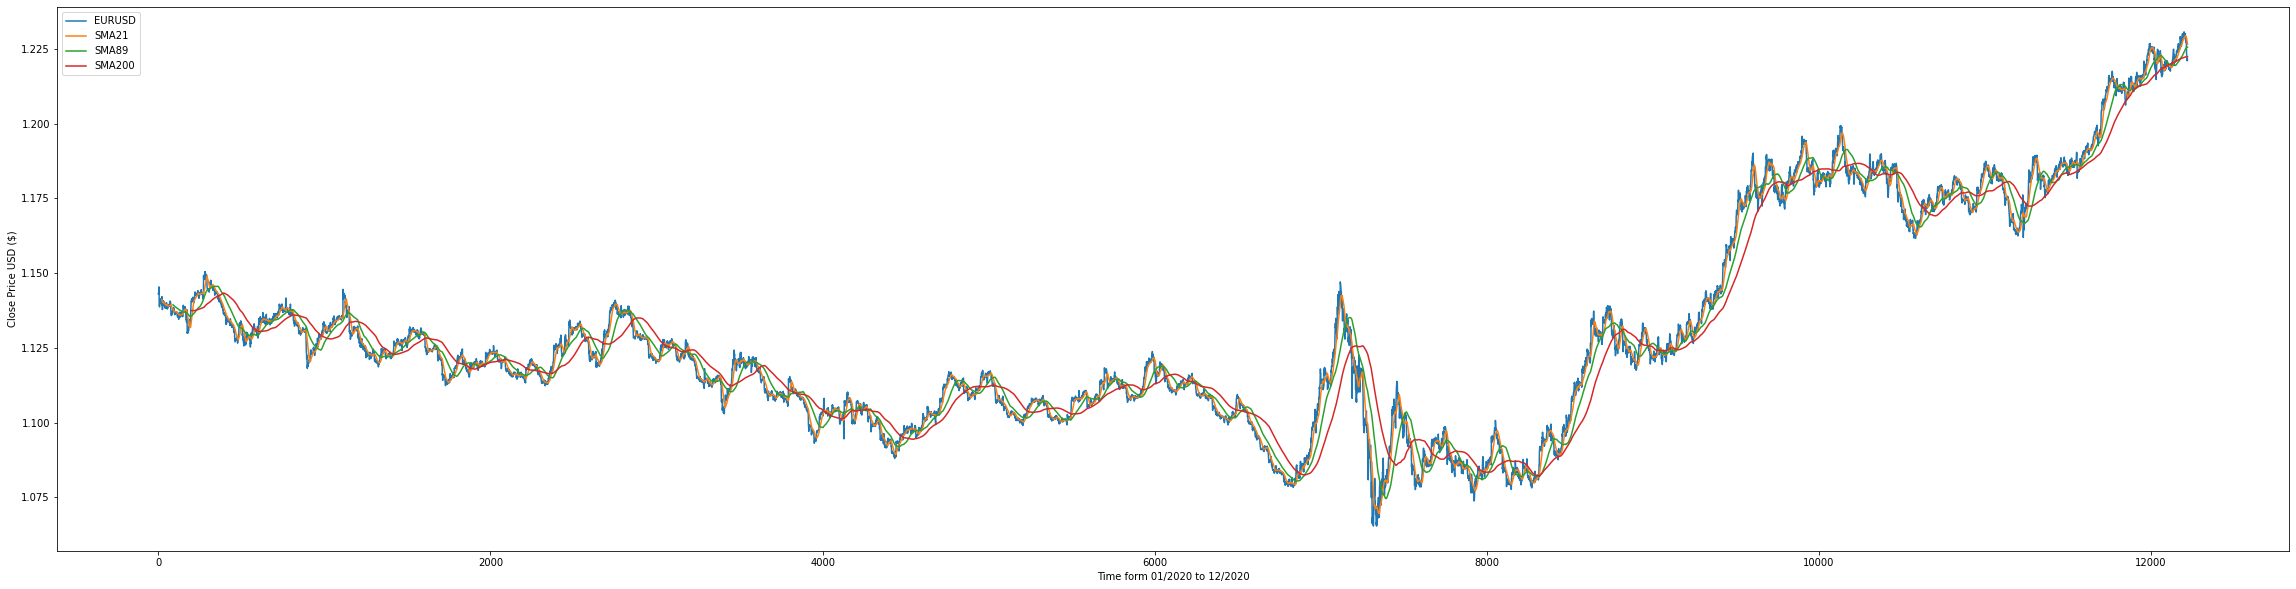

In [ ]:
visual_data = pr.reset_index(drop=True).copy()
sma21 =  pd.DataFrame()
sma21 = visual_data['close'].rolling(21).mean()
#sma20

sma55 =  pd.DataFrame()
sma55 = visual_data['close'].rolling(55).mean()

sma89 =  pd.DataFrame()
sma89 = visual_data['close'].rolling(89).mean()

sma200 =  pd.DataFrame()
sma200 = visual_data['close'].rolling(200).mean()

plt.figure(figsize=(40,10))
plt.plot(visual_data['close'], label="EURUSD")
plt.plot(sma21, label="SMA21")
plt.plot(sma89, label="SMA89")
plt.plot(sma200, label="SMA200")
plt.xlabel("Time form 01/2020 to 12/2020")
plt.ylabel("Close Price USD ($)")
plt.legend(loc='upper left')
plt.show()

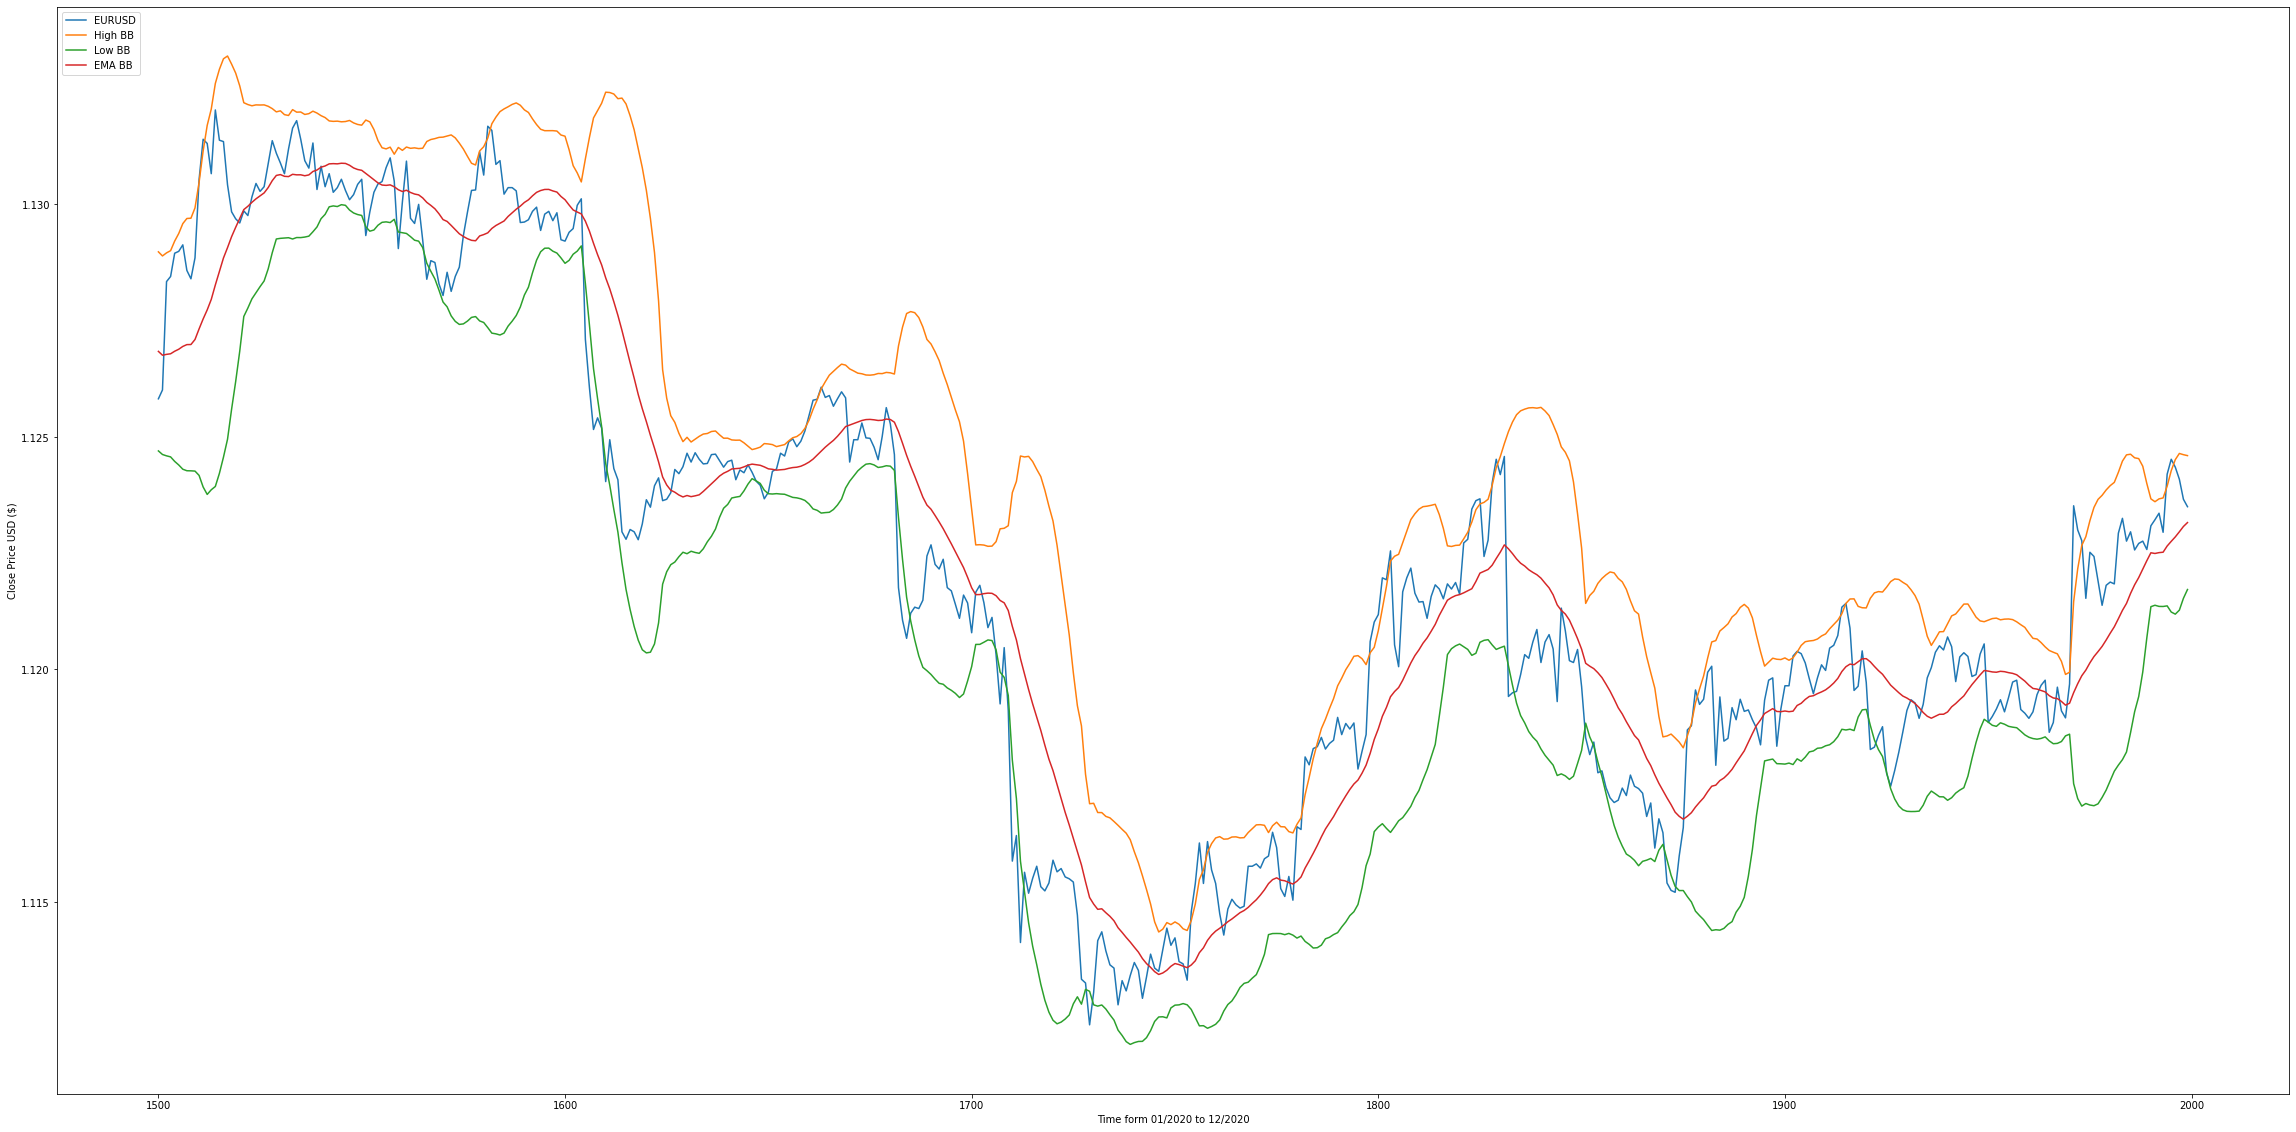

In [ ]:

visual_data['Buy_Signal'] = Buy
visual_data['Sell_signal'] = Sell

#plt.figure(figsize=(40,20))
#plt.plot(visual_data['close'], label="EURUSD")
#plt.scatter(visual_data.index, visual_data['Buy_Signal'], color='green', label='Buy', marker='^', alpha=1)
#plt.scatter(visual_data.index, visual_data['Sell_signal'], color='red', label='Sell', marker='v', alpha=1)
#plt.xlabel("Time form 01/2020 to 12/2020")
#plt.ylabel("Close Price USD ($)")
#plt.legend(loc='upper left')
#plt.show()

indexStart = 12100
limit_visual_data = visual_data[1500:2000]
plt.figure(figsize=(40,20))
plt.plot(limit_visual_data['close'], label="EURUSD")
plt.plot(limit_visual_data.volatility_bbh, label='High BB')
plt.plot(limit_visual_data.volatility_bbl, label='Low BB')
plt.plot(limit_visual_data.volatility_bbm, label='EMA BB')
#plt.scatter(limit_visual_data.index, limit_visual_data['Buy_Signal'], color='green', label='Buy', marker='^', alpha=1)
#plt.scatter(limit_visual_data.index, limit_visual_data['Sell_signal'], color='red', label='Sell', marker='v', alpha=1)
plt.xlabel("Time form 01/2020 to 12/2020")
plt.ylabel("Close Price USD ($)")
plt.legend(loc='upper left')
plt.show()

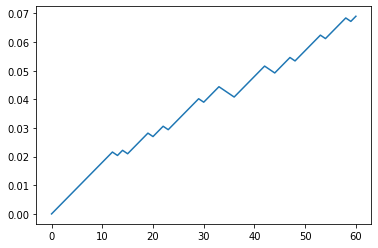

In [ ]:
def tester(dataset, sl, tp, spread = 0.0, plot = False):
    last_deal = int(2)
    last_price = 0.0
    report = [0.0]
    for i in range(dataset.shape[0]):
        pred = dataset['labels'][i]
        if last_deal == 2:
            last_price = dataset['close'][i]
            last_deal = 0 if pred < 0.5 else 1
            continue
        if last_deal == 0:
            if last_price + sl < dataset['high'][i]:
                report.append(report[-1] - spread - sl)
                last_deal = 2
                continue
            if last_price - tp > dataset['low'][i]:
                report.append(report[-1] - spread + tp)
                last_deal = 2
            continue
        if last_deal == 1:
            if last_price - sl > dataset['low'][i]:
                report.append(report[-1] - spread - sl)
                last_deal = 2
                continue
            if last_price + tp < dataset['high'][i]:
                report.append(report[-1] - spread + tp)
                last_deal = 2

    y = np.array(report).reshape(-1,1)
    X = np.arange(len(report)).reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X,y)

    l = lr.coef_
    if l >= 0:
        l = 1
    else:
        l = -1

    if(plot):
        plt.plot(report)
        plt.show()

    return lr.score(X,y) * l

res = tester(pr_labels, STOPLOSS, TAKEPROFIT, SPREAD, plot=True)

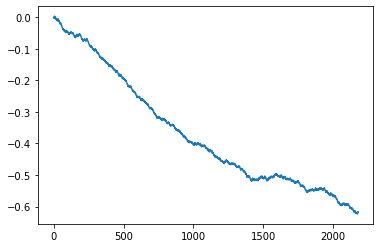

Iteration:  0 R^2:  -0.9452730997706124


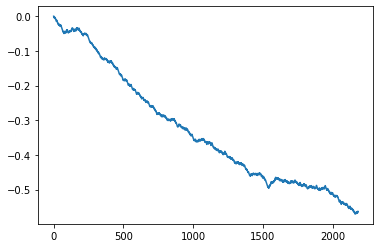

Iteration:  1 R^2:  -0.9563454770915628


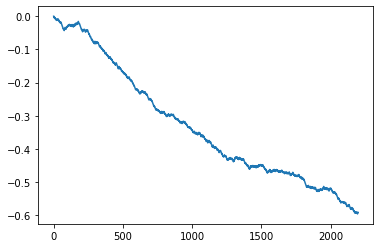

Iteration:  2 R^2:  -0.9602310143618565


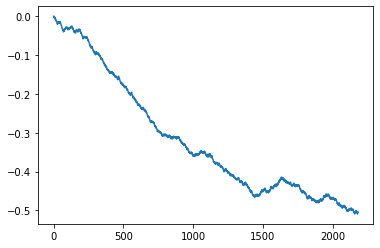

Iteration:  3 R^2:  -0.9136194558806433


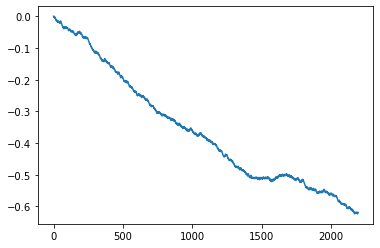

Iteration:  4 R^2:  -0.9600528681585517


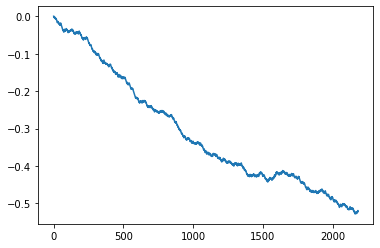

Iteration:  5 R^2:  -0.9502352149123718


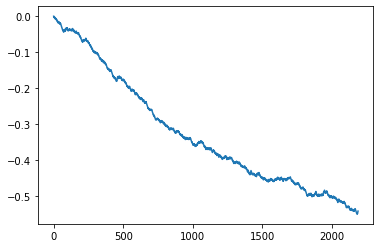

Iteration:  6 R^2:  -0.9505094775287085


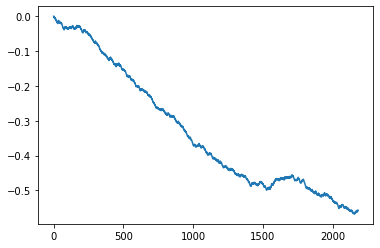

Iteration:  7 R^2:  -0.9423612653748


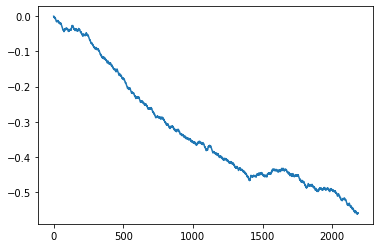

Iteration:  8 R^2:  -0.9330513573205079


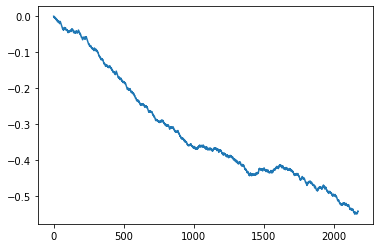

Iteration:  9 R^2:  -0.9348186667296178


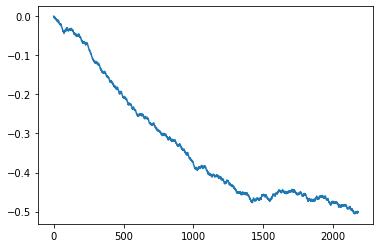

Iteration:  10 R^2:  -0.8873425755883926


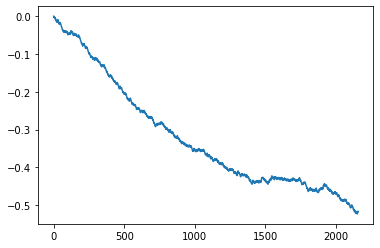

Iteration:  11 R^2:  -0.9158761101926587


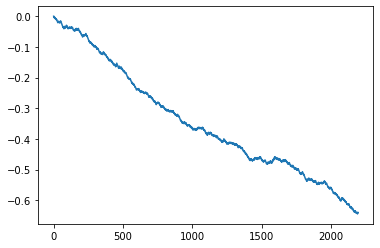

Iteration:  12 R^2:  -0.9744893161756513


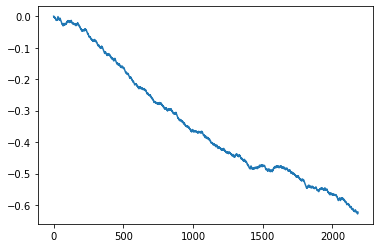

Iteration:  13 R^2:  -0.9675188097739509


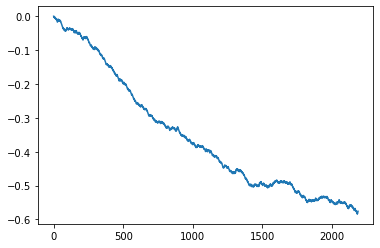

Iteration:  14 R^2:  -0.9393010091363285


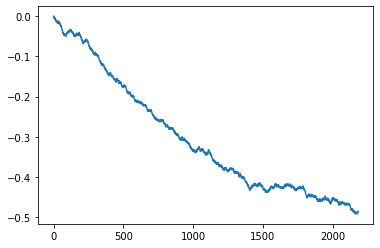

Iteration:  15 R^2:  -0.9360269095025138


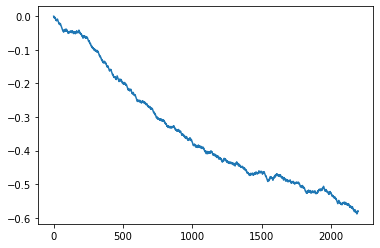

Iteration:  16 R^2:  -0.9442977397570343


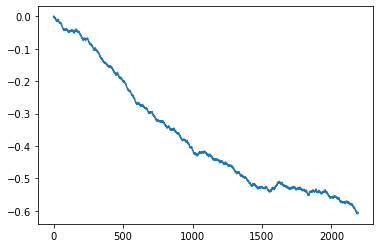

Iteration:  17 R^2:  -0.9265338448619314


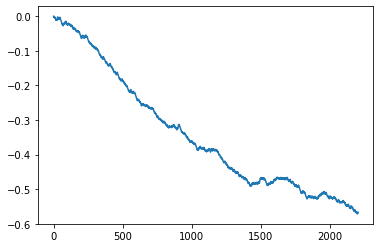

Iteration:  18 R^2:  -0.9401022250874217


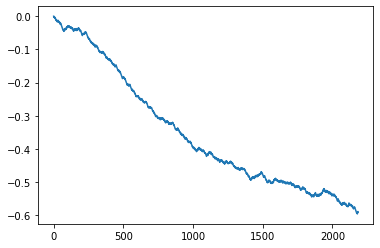

Iteration:  19 R^2:  -0.9391964121015244


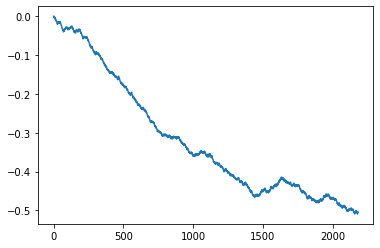

-0.9136194558806433

In [ ]:
# perform GMM clasterizatin over dataset
from sklearn import mixture
pr_c = pr_labels.copy()
X = pr_c[pr_c.columns[1:]]
gmm = mixture.GaussianMixture(n_components=75, covariance_type='full',n_init=1).fit(X)

# plot resampled components
# generated = gmm.sample(5000)
# gen = pd.DataFrame(generated[0])
# gen.rename(columns={ gen.columns[-1]: "labels" }, inplace = True)
# gen.loc[gen['labels'] >= 0.5, 'labels'] = 1
# gen.loc[gen['labels'] < 0.5, 'labels'] = 0
# pca_plot(gen)
# brute force loop
def brute_force(samples = 5000):
    # sample new dataset
    generated = gmm.sample(samples)
    # make labels 
    gen = pd.DataFrame(generated[0])
    gen.rename(columns={ gen.columns[-1]: "labels" }, inplace = True)
    gen.loc[gen['labels'] >= 0.5, 'labels'] = 1
    gen.loc[gen['labels'] < 0.5, 'labels'] = 0
    #pca_plot(gen)
    X = gen[gen.columns[:-1]]
    y = gen[gen.columns[-1]]
    # train\test split
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.5, test_size = 0.5, shuffle=True)
    #learn with train and validation subsets
    #print("Do brute force CatBoostClassifier")
    model = CatBoostClassifier(iterations=500,
                            depth=6,
                            learning_rate=0.1,
                            custom_loss=['Accuracy'],
                            eval_metric='Accuracy',       
                            verbose=False, 
                            use_best_model=True,
                            task_type='CPU')
    model.fit(train_X, train_y, eval_set = (test_X, test_y), early_stopping_rounds=25, plot=False)
    # test on new data
    pr_tst = v2get_prices_test(TSTART_DATE, START_DATE)
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)

    #test the learned model
    p = model.predict_proba(X)
    p2 = [x[0]<0.5 for x in p]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2
    R2 = tester(pr2, STOPLOSS, TAKEPROFIT, SPREAD, plot=True)

    return [R2, samples, model]

def test_model(result):
    pr_tst = v2get_prices_test(TSTART_DATE, STOP_DATE)
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)

    #test the learned model
    p = result[2].predict_proba(X)
    p2 = [x[0]<0.5 for x in p]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2
    R2 = tester(pr2, STOPLOSS, TAKEPROFIT, SPREAD, plot=True)

# iterative learning
res = []
for i in range(20):  
    res.append(brute_force(10000))
    print('Iteration: ', i, 'R^2: ', res[-1][0])

# test best model
res.sort()
test_model(res[-2])
res[-2][0]


In [ ]:

# export best model to mql
export_model_to_MQL_code(res[-1][2])


The file cat_model.mqh has been written to disc
